In [12]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
from spright import RMRelation 

import scienceplots

plt.style.use(('science','no-latex','bright','seaborn-v0_8-poster'))

#Single-column figures: The maximum width is 8.5 cm (3.35 inches).
#Double-column figures: The maximum width is 17.8 cm (7 inches).


In [13]:
from cosmic_shoreline import CosmicShoreline

cs = CosmicShoreline()

# 1. Sample Preparation

In [14]:
df = pd.read_csv('./exoplanets_data/TSM/NASAExoArchive_2025-03-20_aggregate.csv',keep_default_na=True,low_memory=False)

# make the minimum mass from RV as the real mass
df['pl_masse']=df['pl_bmasse']
df['pl_masseerr2']=df['pl_bmasseerr2']
df['pl_masseerr1']=df['pl_bmasseerr1']


#  remove maximum mass
df['pl_masse'] = np.where(df['pl_bmasselim']==1, np.nan, df['pl_masse'])

# calculated the mass from radius assuming earth-like composition
masse_calc = cs.M_R_fit(df['pl_rade'].to_numpy(),x_M_or_R='R')
df['pl_masse_calc'] = np.where(df['pl_masse'].isna(),masse_calc,df['pl_masse'])
df['pl_g'] = 9.81*df['pl_masse']/(df['pl_rade'])**2
df['pl_rho_ratio'] = cs.M_R_fit(df['pl_masse'].to_numpy(),x_M_or_R='M')**3/df['pl_rade']**3


# remove planets above radius valley (Ho and Van Eylen 2024) (applied to 0.6-1.4 M_odot)
# Mask for planets with st_mass < 0.6: exclude those with pl_rade > 1.5 if pl_masse is NaN
mask_low_mass = (df['st_mass'] < 0.6) & (((df['pl_rade']<1.5) & df['pl_masse'].isna())| ((df['pl_rho_ratio']>0.6) & (df['pl_masse']<10)))

# Mask for rows with 0.6 <= st_mass < 1.4 that satisfy the filter condition
mask_middle = (
    (df['st_mass'] >= 0.6) & (df['st_mass'] < 1.4) &
    (np.log10(df['pl_rade']) < (-0.11 * np.log10(df['pl_orbper']) + 0.37))
)

# Combine the masks
mask = (mask_low_mass | mask_middle)

# Apply the combined mask to the DataFrame
df_rocks = df[mask]

# remove planets with mass < 0.5 M_earth

# calculate escape velocity
earth_mass = 5.972e24
G = 6.67430e-11
earth_radius = 6.371e6

df_rocks['pl_vesc'] = np.sqrt(2*G*earth_mass*df_rocks['pl_masse_calc']/(df_rocks['pl_rade']*earth_radius))/(1e3)


/home/xuanji/ipykernel_1875665/2179914354.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rocks['pl_vesc'] = np.sqrt(2*G*earth_mass*df_rocks['pl_masse_calc']/(df_rocks['pl_rade']*earth_radius))/(1e3)


In [15]:
# Read the file
df_STSCI_table = pd.read_csv('./exoplanets_data/STSCI_Targets_v2', 
                 skiprows=1,  # Skip the header row
                 names=['Planet_Name', 'Radius', 'Mass', 'Period', 'K_mag', 'T_eff', 'a/R*', 'Rp/R*', 'Teq', 'Priority_Metric'])

df_STSCI_table['Planet_Name']

df_STSCI = df_rocks[df_rocks['pl_name'].isin(df_STSCI_table['Planet_Name'])]

In [16]:
# JWST_Transit_list = 

ds_JWST_transit_list = pd.read_csv('./exoplanets_data/trexolists.csv').Target
df_JWST_transit = df_rocks[df_rocks['hostname'].isin(ds_JWST_transit_list)]

ds_JWST_direct_list = pd.read_csv('./exoplanets_data/diexolists.csv').Target
df_JWST_direct = df_rocks[df_rocks['hostname'].isin(ds_JWST_direct_list)]


In [17]:
TESS_ESM_targets = [
    'TOI-4670.01', 'TOI-5205 b', 'HD189733 b', 'Kepler-1935 b', 'WASP-76 b', 'WASP-33 b', 'TOI-706.01',
    'TOI-5023.01', 'TOI-6137.01', 'HD209458 b', 'KELT-7 b', 'KELT-20 b', 'TOI-5311.01', 'TOI-6626.01',
    'TOI-6801.01', 'WASP-77A b', 'HAT-P-32 b', 'WASP-189 b', 'TOI-6508.01', 'TOI-519 b', 'TOI-507.01',
    'WASP-43 b', 'WASP-19 b', 'WASP-18 b', 'TOI-6601.01', 'TOI-1130 c', 'TOI-6055.01', 'K2-31 b',
    'KELT-4A b', 'WASP-121 b', 'TOI-2134 c', 'TOI-4860 b', 'HAT-P-20 b', 'HIP65A b', 'LTT9779 b',
    'TOI-6093.01', 'TOI-5579.01', 'TOI-2640.01', 'TOI-2341.01', 'TOI-1408 b', 'TOI-1254.01',
    'TOI-906.01', 'TOI-5575.01', 'TOI-5695.01', 'HAT-P-3 b', 'TOI-564 b', 'TOI-5019.01', 'TOI-5179.01',
    'K2-387 b', 'TOI-674 b', 'TOI-6110.01', 'HD149026 b', 'TOI-1954.01', 'TOI-5907.01', 'TOI-1104.01',
    'WASP-132 b', 'WASP-29 b', 'TOI-2641 b', 'TOI-6360.01', 'TOI-6010.01', 'TOI-4506.01', 'GJ436 b',
    'TOI-5800.01', 'Kepler-1979 b', 'TOI-851.01', 'TOI-1546.01', 'TOI-1231 b', 'AU Mic b', 'TOI-5938.01',
    'K2-266 b', 'TOI-849 b', 'TOI-5738.02', 'TOI-620 b', 'TOI-1130 b', 'Kepler-1907 c', 'TOI-332 b',
    'TOI-4632.01', 'AU Mic c', 'TOI-5486.01', 'TOI-1252.01', 'TOI-1293.01', 'TOI-2088.01', 'HD73583 b',
    'TOI-2768.01', 'TOI-824 b', 'TOI-5345.01', 'TOI-1468 c', 'Kepler-283 c', 'HD219134 b', 'Kepler-1862 b',
    '55 Cnc e', 'TOI-2260 b', 'TOI-4336A b', 'GJ1214 b', 'TOI-6940.01', 'Kepler-24 e', 'K2-370 b',
    'TOI-2324.01', 'TOI-5713.01', 'HD219134 c', 'pi Men c', 'TOI-5955.01', 'HD213885 b', 'TOI-539.01',
    'TOI-1452 b', 'TOI-277 b', 'TOI-2427 b', 'HR858 b', 'HD3167 b', 'TOI-6260.01', 'TOI-6002.01',
    'GJ3090 b', 'TOI-6717.01', 'TOI-1075 b', 'K2-100 b', 'HD80653 b', 'TRAPPIST-1 c', 'GJ486 b',
    'LHS3844 b', 'TOI-6255.01', 'Kepler-1984 b', 'TOI-561 b', 'Gliese 12 b', 'HD260655 b', 'GJ806 b',
    'GJ367 b', 'TOI-431 b', 'TOI-1444 b', 'TOI-6714.01', 'GJ1132 b', 'TOI-4552.01', 'TOI-1263.01',
    'K2-141 b', 'TOI-801.01', 'TRAPPIST-1 d', 'L98-59 c', 'TOI-6324.01', 'TOI-500 b', 'TOI-1807 b',
    'K2-183 b', 'LP890-9 c', 'LTT1445A c', 'GJ1252 b', 'TOI-864.01', 'TOI-1860 b', 'Kepler-1107 b'
]

df_ESM = df_rocks[df_rocks['pl_name'].isin(TESS_ESM_targets)]

In [18]:
TESS_TSM_targets = [
    'TOI-6508.01', 'WASP-107 b', 'HD189733 b', 'HD209458 b', 'HAT-P-67 b', 'WASP-33 b', 'TOI-4670.01',
    'TOI-5268.01', 'WASP-69 b', 'WASP-127 b', 'TOI-4597.01', 'KELT-20 b', 'TOI-6601.01', 'TOI-6368.01',
    'TOI-1420 b', 'WASP-193 b', 'WASP-76 b', 'WASP-121 b', 'TOI-5311.01', 'TOI-2455.01', 'WASP-39 b', 'KELT-11 b',
    'TOI-5806.01', 'WASP-189 b', 'TOI-1861.01', 'TOI-6626.01', 'TOI-7003.01', 'WASP-94A b', 'HAT-P-32 b',
    'WASP-178 b', 'TOI-2134 c', 'K2-141 c', 'HAT-P-26 b', 'WASP-166 b', 'LTT9779 b', 'TOI-906.01', 'TOI-5575.01',
    'TOI-3884 b', 'DSTucA b', 'HD149026 b', 'TOI-1254.01', 'TOI-5179.01', 'TOI-5579.01', 'TOI-6894.01',
    'TOI-1136 d', 'TOI-659.01', 'TOI-1954.01', 'TOI-6093.01', 'TOI-1104.01', 'GJ3470 b', 'TOI-1135 b',
    'TOI-1264.01', 'TOI-6360.01', 'TOI-2226.01', 'Kepler-16 b', 'TOI-674 b', 'HD332231 b', 'TOI-4425.01',
    'TOI-570.01', 'TOI-6010.01', 'TOI-4506.01', 'GJ436 b', 'TOI-5800.01', 'TOI-1252.01', 'TOI-851.01',
    'TOI-1546.01', 'TOI-1231 b', 'AU Mic b', 'HD191939 b', 'K2-266 b', 'TOI-5951.01', 'TOI-6985.01', 'AU Mic c',
    'TOI-5140.01', 'TOI-3350.01', 'TOI-1293.01', 'TOI-5724.01', 'HD136352 c', 'TOI-4537.01', 'TOI-824 b',
    'TOI-4340.01', 'TOI-4632.01', 'HD191939 d', 'HD73344 b', 'HD93963A c', 'TOI-2513.01', 'TOI-4336A b', 'GJ1214 b',
    'pi Men c', 'HR858 b', '55 Cnc e', 'TOI-6260.01', 'TOI-1468 c', 'L98-59 d', 'HD219134 b', 'HR858 c', 'HD3167 b', 'TOI-2260 b',
    'LHS1140 b', 'GJ3090 b', 'HD63433 b', 'TOI-5955.01', 'K2-370 b', 'TOI-2324.01', 'TOI-6002.01', 'HD219134 c',
    'TOI-544 b', 'HD86226 c', 'TOI-4644.01', 'TOI-539.01', 'TOI-5713.01', 'HD260655 c', 'HD136352 b', 'TOI-1416 b',
    'TOI-1242.01', 'TOI-2590.01', 'TRAPPIST-1 d', 'LTT1445A c', 'GJ806 b', 'TOI-6255.01', 'K2-137 b', 'TOI-561 b',
    'TRAPPIST-1 c', 'TOI-540 b', 'LHS3844 b', 'GJ367 b', 'TOI-1807 b', 'TOI-801.01', 'TRAPPIST-1 e', 'SPECULOOS-3 b',
    'TOI-6324.01', 'TOI-4307.02', 'TOI-431 b', 'TOI-1444 b', 'TRAPPIST-1 f', 'L98-59 b', 'GJ1252 b', 'TOI-500 b',
    'TOI-1860 b', 'K2-223 b', 'TRAPPIST-1 h', 'GJ486 b', 'TOI-6662.01', 'TOI-864.01', 'K2-141 b', 'K2-157 b']

df_TSM = df_rocks[df_rocks['pl_name'].isin(TESS_TSM_targets)]

# 2. Table Generation

In [19]:
CS_insol_001_tb = np.load('./data-montecarlo/CS_V2_insol_001_pl_vesc.npy')
CS_insol_01_tb = np.load('./data-montecarlo/CS_V2_insol_01_pl_vesc.npy')
CS_insol_05_tb = np.load('./data-montecarlo/CS_V2_insol_05_pl_vesc.npy')

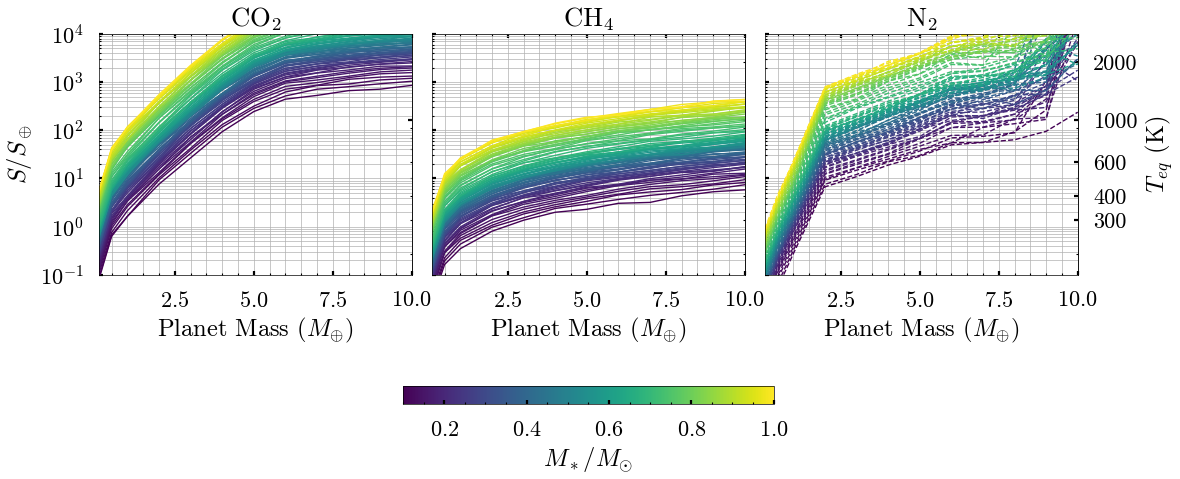

In [20]:
import matplotlib as mpl

MMWs = [44, 16, 28]
planet_masses = [0.1,0.5,1,2,3,4,5,6,7,8,9,10]
# stellar_mass_range = [[0.1,0.2], [0.2,0.4], [0.4,0.6], [0.6,0.8],[0.8,1.0]]
stellar_mass_range = [[x, x+0.01] for x in np.arange(0.1,1.001,0.01)]

pl_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_rades = cs.M_R_fit(pl_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*pl_masses*cs.earth_mass/(pl_rades*6.371e6))/1e3


fig, axes = plt.subplots(1, 3, figsize=(12,5),sharex=True,sharey=True)

colors = mpl.cm.viridis(np.linspace(0,1,len(stellar_mass_range)))
ls = ['-', '-', '--']
for n_x, MMW in enumerate(MMWs):
    for n_st, stellar_mass in enumerate(stellar_mass_range):
        axes[n_x].plot(pl_masses,CS_insol_01_tb[n_x,n_st,:,1],c=colors[n_st],lw=1,ls=ls[n_x])

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(0.1,10)
    ax.set_ylim(0.1,1e4)

axes[0].set_title('CO$_2$')
axes[1].set_title('CH$_4$')
axes[2].set_title('N$_2$')

axes[0].set_ylabel(r'$S/S_\oplus$')
axes[0].set_xlabel('Planet Mass ($M_{\oplus}$)')
axes[1].set_xlabel('Planet Mass ($M_{\oplus}$)')
axes[2].set_xlabel('Planet Mass ($M_{\oplus}$)')

# Conversion functions
def S_to_Teq(S):
    """Convert insolation S to equilibrium temperature T_eq."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (S * 1361 / 4 / sigma) ** 0.25

def Teq_to_S(Teq):
    """Convert equilibrium temperature T_eq back to insolation S."""
    # Constants
    sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
    return (Teq**4 * sigma) / (1361/4)

for n_ax,ax in enumerate(axes):
    ax.tick_params(axis='y',which='both', right=False)
    ax2 = ax.secondary_yaxis('right', functions=(S_to_Teq, Teq_to_S))
    ax.grid(True, which="both", ls="-", lw=0.5)
    if n_ax<2:
        ax2.tick_params(axis='y',which='both',labelright=False)
    else:
        ax2.set_ylabel('$T_{eq}$ (K)')
        ax2.set_yticks([300,400,600,1000,2000])
        ax2.set_yticklabels(['300','400','600','1000','2000'])
        
fig.tight_layout(w_pad=0)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0.1, vmax=1.0), cmap='viridis'), ax=axes.ravel().tolist(), orientation='horizontal',fraction=0.05, pad=0.3)
cbar.set_label(r'$M_*/M_{\odot}$')


fig.savefig('./figures/CS_V2_insol_vs_mass.pdf',bbox_inches='tight')


In [21]:
df_combined = pd.concat([df_JWST_transit,df_JWST_direct,df_TSM,df_ESM,df_STSCI])
len(df_combined)

# Remove duplicates based on planet name
df_combined = df_combined.drop_duplicates(subset='pl_name', keep='first')

# Get the count of unique planets
unique_planets_count = len(df_combined)
print(f"Number of unique exoplanets in the combined dataset: {unique_planets_count}")
print('JWST',len(df_JWST_transit),len(df_JWST_direct))
print('TSM',len(df_TSM))
print('ESM',len(df_ESM))
print('STSCI',len(df_STSCI))

# Display the first few rows of the unique planets dataset
df_combined.head()

Number of unique exoplanets in the combined dataset: 100
JWST 31 0
TSM 21
ESM 19
STSCI 70


,Unnamed: 0,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,tran_flag,...,efficiency_kmag,ed_ESM,ESM,pl_masse,pl_masseerr2,pl_masseerr1,pl_masse_calc,pl_g,pl_rho_ratio,pl_vesc
422,422,K2-141 b,K2-141,1,1,2,Transit,2018,K2,1,...,0.931624,167.092438,14.969734,4.97,-0.34,0.35,4.970000,21.383141,1.064759,20.293814
535,535,K2-22 b,K2-22,1,2,1,Transit,2015,K2,1,...,1.000000,362.568641,6.412798,NaN,NaN,NaN,27.805500,NaN,NaN,38.893354
1821,1821,Kepler-167 b,Kepler-167,1,2,4,Transit,2014,Kepler,1,...,1.000000,37.952405,0.700320,NaN,NaN,NaN,7.654782,NaN,NaN,23.611784
1822,1822,Kepler-167 c,Kepler-167,1,2,4,Transit,2014,Kepler,1,...,1.000000,23.916342,0.441318,NaN,NaN,NaN,6.907537,NaN,NaN,22.722591
1823,1823,Kepler-167 d,Kepler-167,1,2,4,Transit,2016,Kepler,1,...,1.000000,4.607663,0.085023,NaN,NaN,NaN,2.160215,NaN,NaN,14.776179


In [22]:
MMWs = [44, 16, 28]
planet_masses = [0.1,0.5,1,2,3,4,5,6,7,8,9,10]
# stellar_mass_range = [[0.1,0.2], [0.2,0.4], [0.4,0.6], [0.6,0.8],[0.8,1.0]]
stellar_mass_range = [[x, x+0.01] for x in np.arange(0.1,1.001,0.01)]
st_mass0_arr = np.arange(0.1,1.001,0.01)

pl_masses = np.array([0.1,0.5,1,2,3,4,5,6,7,8,9,10])
pl_rades = cs.M_R_fit(pl_masses, x_M_or_R='M')
pl_v_esc = np.sqrt(2*6.67430e-11*pl_masses*earth_mass/(pl_rades*6.371e6))/1e3


for i, item in df_combined.iterrows():
    n_st = np.argmin(np.abs(st_mass0_arr-item['st_mass']))
    CS_insol = CS_insol_01_tb[0,n_st,:,1]
    cs_interp = scipy.interpolate.interp1d(pl_v_esc, np.log10(CS_insol), kind='linear', fill_value='extrapolate')
    pl_loginsol_cri = cs_interp(item['pl_vesc'])
    score = pl_loginsol_cri - np.log10(item['pl_insol'])
    df_combined.loc[i,'score_CO2'] = score

for i, item in df_combined.iterrows():
    n_st = np.argmin(np.abs(st_mass0_arr-item['st_mass']))
    CS_insol = CS_insol_01_tb[1,n_st,:,1]
    cs_interp = scipy.interpolate.interp1d(pl_v_esc, np.log10(CS_insol), kind='linear', fill_value='extrapolate')
    pl_loginsol_cri = cs_interp(item['pl_vesc'])
    score = pl_loginsol_cri - np.log10(item['pl_insol'])
    df_combined.loc[i,'score_CH4'] = score

for i, item in df_combined.iterrows():
    n_st = np.argmin(np.abs(st_mass0_arr-item['st_mass']))
    CS_insol = CS_insol_01_tb[2,n_st,:,1]
    cs_interp = scipy.interpolate.interp1d(pl_v_esc, np.log10(CS_insol), kind='linear', fill_value='extrapolate')
    pl_loginsol_cri = cs_interp(item['pl_vesc'])
    score = pl_loginsol_cri - np.log10(item['pl_insol'])
    df_combined.loc[i,'score_N2O2'] = score
    
    # for n_st, stellar_mass in enumerate(stellar_mass_range):
    #     axes[n_x].plot(pl_masses,CS_insol_01_tb[n_x,n_st,:,1],c=colors[n_st],lw=1,ls=ls[n_x])


In [23]:
df_targets = df_combined.sort_values('score_CO2',ascending=False)
df_targets.to_csv('./figures/CS_exoplanets.csv',index=False)

print(len(df_targets['pl_name']))
df_targets




100


,Unnamed: 0,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,tran_flag,...,pl_masse,pl_masseerr2,pl_masseerr1,pl_masse_calc,pl_g,pl_rho_ratio,pl_vesc,score_CO2,score_CH4,score_N2O2
3633,3633,LHS 1140 b,LHS 1140,1,1,2,Transit,2017,MEarth Project,1,...,5.60,-0.19,0.19,5.600000,18.355441,0.774588,20.125418,3.173013,1.163745,2.198413
1822,1822,Kepler-167 c,Kepler-167,1,2,4,Transit,2014,Kepler,1,...,NaN,NaN,NaN,6.907537,NaN,NaN,22.722591,2.450191,0.218600,1.827375
3798,3798,TOI-1452 b,TOI-1452,1,2,1,Transit,2022,Transiting Exoplanet Survey Satellite (TESS),1,...,4.82,-1.30,1.30,4.820000,16.913890,0.765481,18.992378,2.406130,0.614935,1.631413
3882,3882,TOI-198 b,TOI-198,1,1,1,Transit,2023,Transiting Exoplanet Survey Satellite (TESS),1,...,NaN,NaN,NaN,3.816945,NaN,NaN,18.211708,2.333757,0.669141,1.753679
1821,1821,Kepler-167 b,Kepler-167,1,2,4,Transit,2014,Kepler,1,...,NaN,NaN,NaN,7.654782,NaN,NaN,23.611784,2.201172,-0.023336,1.528480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,539,K2-223 b,K2-223,1,1,2,Transit,2018,K2,1,...,NaN,NaN,NaN,0.668045,NaN,NaN,9.691296,-1.880997,-2.437948,-2.734691
3636,3636,LHS 1678 b,LHS 1678,1,2,3,Transit,2021,Transiting Exoplanet Survey Satellite (TESS),1,...,NaN,NaN,NaN,0.273241,NaN,NaN,7.064823,-1.905247,-2.382783,-2.824381
412,412,K2-137 b,K2-137,1,1,1,Transit,2017,K2,1,...,NaN,NaN,NaN,0.216820,NaN,NaN,6.510796,-3.100589,-3.600554,-4.034502
2133,2133,Kepler-1907 c,Kepler-1907,1,1,2,Transit,2021,Kepler,1,...,NaN,NaN,NaN,1.680300,NaN,NaN,13.492002,NaN,NaN,NaN


In [24]:
df_best = df_targets[(df_targets['score_CO2']>0) & (df_targets['score_CH4']>0) & (df_targets['score_N2O2']>0)]

for pl_name in df_best['pl_name']:
    print(pl_name)

LHS 1140 b
Kepler-167 c
TOI-1452 b
TOI-198 b
TOI-776 b
TOI-260 b
TOI-1680 b
TOI-237 b
LP 890-9 c
TOI-700 d
Kepler-167 d
TRAPPIST-1 g


In [25]:
# Convert the DataFrame to a LaTeX table string
df_targets_print = df_targets.fillna('-')
latex_table = df_targets_print.to_latex(index=False,float_format="%.2f")

# Print the LaTeX table to the console
print(latex_table)

# Optionally, you can save it to a .tex file
with open("table_with_ranks.tex", "w") as f:
    f.write(latex_table)

\begin{tabular}{rllrrrlrlrlrlrllrllllrllrrllrlllllllllllllllllllllllllrllllllllrlllllllllrllrrllrrllrlllllllllllrlrlllrrrrrrrrrrrrrrrlllllllllrrlrrlllllrllrlll}
\toprule
Unnamed: 0 & pl_name & hostname & default_flag & sy_snum & sy_pnum & discoverymethod & disc_year & disc_facility & tran_flag & soltype & pl_controv_flag & pl_refname & pl_orbper & pl_orbpererr1 & pl_orbpererr2 & pl_orbperlim & pl_orbsmax & pl_orbsmaxerr1 & pl_orbsmaxerr2 & pl_orbsmaxlim & pl_rade & pl_radeerr1 & pl_radeerr2 & pl_radelim & pl_radj & pl_radjerr1 & pl_radjerr2 & pl_radjlim & pl_bmasse & pl_bmasseerr1 & pl_bmasseerr2 & pl_bmasselim & pl_bmassj & pl_bmassjerr1 & pl_bmassjerr2 & pl_bmassjlim & pl_bmassprov & pl_orbeccen & pl_orbeccenerr1 & pl_orbeccenerr2 & pl_orbeccenlim & pl_insol & pl_insolerr1 & pl_insolerr2 & pl_insollim & pl_eqt & pl_eqterr1 & pl_eqterr2 & pl_eqtlim & pl_orbincl & pl_orbinclerr1 & pl_orbinclerr2 & pl_orbincllim & ttv_flag & pl_trandur & pl_trandurerr1 & pl_trandurerr2 & pl_trandurlim &